In [6]:
# Install the required libraries
# pip install torch transformers datasets scikit-learn matplotlib seaborn shap
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, AdamW
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import shap


In [7]:
# Load dataset
c_names = [
    "duration", "protocol_type", "service", "flag", "src_bytes", "dst_bytes",
    "land", "wrong_fragment", "urgent", "hot", "num_failed_logins", "logged_in",
    "num_compromised", "root_shell", "su_attempted", "num_root", "num_file_creations",
    "num_shells", "num_access_files", "num_outbound_cmds", "is_host_login", "is_guest_login",
    "count", "srv_count", "serror_rate", "srv_serror_rate", "rerror_rate", "srv_rerror_rate",
    "same_srv_rate", "diff_srv_rate", "srv_diff_host_rate", "dst_host_count", "dst_host_srv_count",
    "dst_host_same_srv_rate", "dst_host_diff_srv_rate", "dst_host_same_src_port_rate",
    "dst_host_srv_diff_host_rate", "dst_host_serror_rate", "dst_host_srv_serror_rate",
    "dst_host_rerror_rate", "dst_host_srv_rerror_rate", "labels", "difficulty_degree"
]

# Load training and testing datasets
train = pd.read_csv("data/KDDTrain+.txt", names=c_names)
test = pd.read_csv("data/KDDTest+.txt", names=c_names)

# Drop 'difficulty_degree' column
train.drop("difficulty_degree", axis=1, inplace=True)
test.drop("difficulty_degree", axis=1, inplace=True)

# Map labels to binary (1: 'normal', 0: 'attack')
train["labels"] = train["labels"].apply(lambda x: 1 if x == "normal" else 0)
test["labels"] = test["labels"].apply(lambda x: 1 if x == "normal" else 0)

# Convert categorical features into a single text format for LLM input
categorical_features = ["protocol_type", "service", "flag"]
numerical_features = [col for col in train.columns if col not in categorical_features + ["labels"]]

def preprocess_data(df):
    df["text"] = df[categorical_features].astype(str).apply(" ".join, axis=1)
    df["text"] = df["text"] + " " + df[numerical_features].astype(str).apply(" ".join, axis=1)
    return df[["text", "labels"]]

train_data = preprocess_data(train)
test_data = preprocess_data(test)


In [8]:
# Define Dataset class for tokenized data
class NSLKDDDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]

        # Tokenize the input text
        tokens = self.tokenizer(
            text,
            max_length=self.max_length,
            padding="max_length",
            truncation=True,
            return_tensors="pt"
        )
        return {
            "input_ids": tokens["input_ids"].squeeze(0),
            "attention_mask": tokens["attention_mask"].squeeze(0),
            "label": torch.tensor(label, dtype=torch.long)
        }

# Tokenizer
tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")

# Create Dataset and DataLoader
max_length = 128
batch_size = 32

train_dataset = NSLKDDDataset(train_data["text"].tolist(), train_data["labels"].tolist(), tokenizer, max_length)
test_dataset = NSLKDDDataset(test_data["text"].tolist(), test_data["labels"].tolist(), tokenizer, max_length)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [9]:
# Define the model
model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=2)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)


In [ ]:
# Training settings
optimizer = AdamW(model.parameters(), lr=5e-5)
criterion = torch.nn.CrossEntropyLoss()

epochs = 20  # Adjust as needed

# Training loop
for epoch in range(epochs):
    model.train()
    total_loss, total_correct = 0, 0

    for batch in train_loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["label"].to(device)

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        logits = outputs.logits
        predictions = torch.argmax(logits, dim=1)
        total_correct += (predictions == labels).sum().item()

        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f"Epoch {epoch + 1}/{epochs}, Loss: {total_loss:.4f}, Accuracy: {total_correct / len(train_dataset):.4f}")


This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning


Epoch 1/10, Loss: 98.3294, Accuracy: 0.9929
Epoch 2/10, Loss: 43.6373, Accuracy: 0.9969
Epoch 3/10, Loss: 31.1438, Accuracy: 0.9976
Epoch 4/10, Loss: 23.7239, Accuracy: 0.9982
Epoch 5/10, Loss: 31.6545, Accuracy: 0.9981
Epoch 6/10, Loss: 15.5834, Accuracy: 0.9989
Epoch 7/10, Loss: 16.2327, Accuracy: 0.9989
Epoch 8/10, Loss: 21.4163, Accuracy: 0.9987
Epoch 9/10, Loss: 280.1946, Accuracy: 0.9700
Epoch 10/10, Loss: 14.3004, Accuracy: 0.9990


In [16]:
# Evaluation loop
model.eval()
all_preds, all_labels = [], []

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["label"].to(device)

        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        predictions = torch.argmax(logits, dim=1)
        all_preds.extend(predictions.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Generate classification report
print(classification_report(all_labels, all_preds, target_names=["Attack", "Normal"]))


              precision    recall  f1-score   support

      Attack       0.92      0.64      0.76     12833
      Normal       0.66      0.92      0.77      9711

    accuracy                           0.77     22544
   macro avg       0.79      0.78      0.77     22544
weighted avg       0.81      0.77      0.76     22544



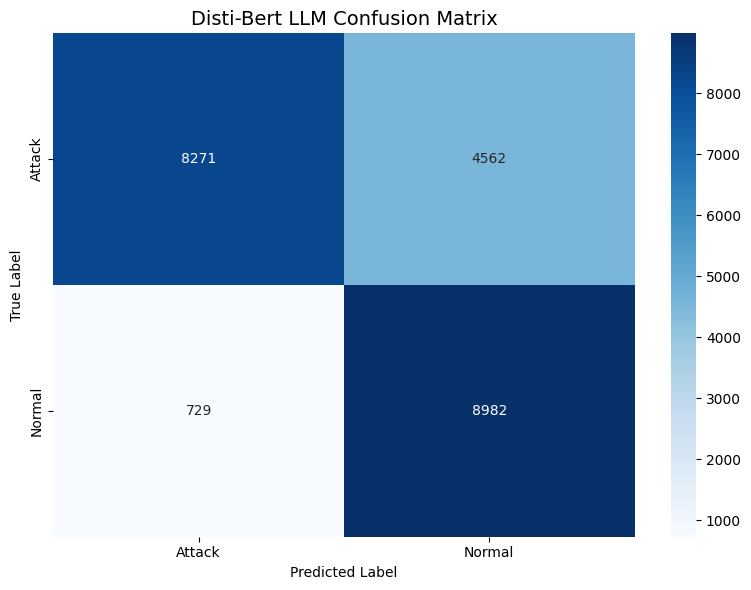

In [18]:
# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Attack", "Normal"], yticklabels=["Attack", "Normal"])
plt.title("Disti-Bert LLM Confusion Matrix", fontsize=14)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.savefig("visualization/DisitBert_confusion_matrix.png")
plt.show()


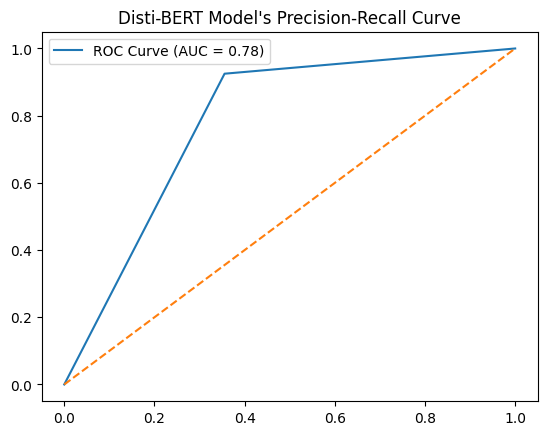

In [ ]:
# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Attack", "Normal"], yticklabels=["Attack", "Normal"])
plt.title("Disti-Bert LLM Confusion Matrix", fontsize=14)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.savefig("visualization/DisitBert_confusion_matrix.png")
plt.show()


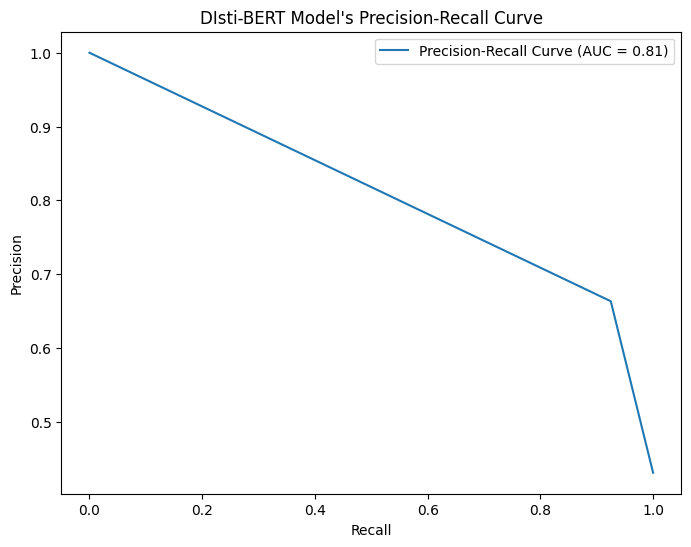

In [21]:
from sklearn.metrics import precision_recall_curve, auc

# Compute Precision-Recall Curve
precision, recall, _ = precision_recall_curve(all_labels, all_preds)
pr_auc = auc(recall, precision)

# Plot Precision-Recall Curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f"Precision-Recall Curve (AUC = {pr_auc:.2f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("DIsti-BERT Model's Precision-Recall Curve")
plt.legend()
plt.savefig("visualization/Disti-Bert_precision_recall_curve.png")  # Save to folder
plt.show()
